In [1]:
# @title Click the play Button Below
print("We are now loading all needed modules...")

!pip install --upgrade cupy-cuda11x
!pip install -q numpy==1.25.0
import os
import numpy as np
if np.__version__ != '1.25.0':
  os.kill(os.getpid(), 9)
!pip install -q pandas==1.5.3
!pip install -q scanpy==1.9.2
!pip install -q seaborn==0.12.2
!pip install -q matplotlib==3.8.1
!pip install -q leidenalg==0.8.10
!pip install -q anndata==0.7.8





print('Importing modules...')
#import numpy as np
print(f'numpy version: {np.__version__}')
if np.__version__ != '1.25.0':
  os.kill(os.getpid(), 9)
import pandas as pd
print(f'pandas version: {pd.__version__}')
import scanpy as sc
print(f'scanpy version: {sc.__version__}')
import seaborn as sns
print(f'seaborn version: {sns.__version__}')
import warnings
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.metrics import silhouette_score
print('Modules imported\n')

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.set_figure_params(figdir='/path/to/your/directory/')

print('Loading all needed functions...')
def make_AnnData(cell_by_gene_path, meta_cell_path, min_count = 0):

    cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
    meta_cell = pd.read_csv(meta_cell_path, index_col=0)

    meta_cell['barcodeCount'] = cell_by_gene.sum(axis=1)

    # initialize meta_gene
    meta_gene = pd.DataFrame(index=cell_by_gene.columns.tolist())

    # Align the cell id of cell_metadata to cell_by_gene
    cell_id = cell_by_gene.index.tolist()
    meta_cell = meta_cell.loc[cell_id]

    # Check again
    if (cell_by_gene.index == meta_cell.index).sum() == len(cell_by_gene.index):
        print('The indices in cell_by_gene and cell_metadata match.')
    else:
        print('The indices in cell_by_gene and cell_metadata do not match.')

    coordinates =np.stack((meta_cell['center_x'], meta_cell['center_y']), axis=1)

    ad = sc.AnnData(X=cell_by_gene.values, obs=meta_cell, var=meta_gene, obsm={"spatial": coordinates})
    return ad

def visualize_clusters(ad, res, spot, name):
    ad.obs['leiden'] = None
    sc.tl.leiden(ad, resolution=res)
    sc.pl.umap(ad, color="leiden", title =f'{name} UMAP')
    sc.pl.spatial(ad, color='leiden', spot_size=spot, title =f'{name} Spatial Plot')
    return


def save_clusters(ad, res, spot, name):
    ad.obs['leiden'] = None
    sc.tl.leiden(ad, resolution=res)
    sc.pl.umap(ad, color="leiden", title =f'{name} UMAP', save=f'{name}.png')
    sc.pl.spatial(ad, color='leiden', spot_size=spot, title =f'{name} Spatial Plot', save=f'{name}.png')
    return


def show_plots():

    plt.figure(figsize=(10, 5))  # Adjust the figure size if needed
    plt.subplot(1, 2, 1)  # If you want to plot both histograms side by side
    ad.obs.barcodeCount.hist(bins=100, range=[0, 500])
    plt.xlabel('Transcript Count')  # Add x-axis label
    plt.ylabel('Frequency')  # Add y-axis label
    plt.title('Distribution of Transcripts per Cell')  # Add a title if desired

    # Plot the second histogram
    plt.subplot(1, 2, 2)  # If you want to plot both histograms side by side
    ad.obs.volume.hist(bins=100, range=[0, 2500])
    plt.xlabel('Cell Volume')  # Add x-axis label
    plt.ylabel('Frequency')  # Add y-axis label
    plt.title('Distribution of Cell Volume')  # Add a title if desired

    plt.show()
    return

def test_resolutions(ad):
    ad_copy = ad.copy()
    resolutions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5]
    #resolutions = [0.25, 0.5, 0.75, 1, 2]
    for res in resolutions:
        ad.obs['leiden'] = None
        sc.tl.leiden(ad_copy, resolution=res)
        sc.pl.umap(ad_copy, color="leiden", title = f"Resolution: {res}")
        sc.pl.spatial(ad_copy, color='leiden', spot_size=30, title = f'Resolution: {res}')
    return


def find_best_resolution(ad):
    resolutions = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5]
    resolutions = [0.25, 0.5, 0.75, 1, 2]
    best_resolution = None
    best_silhouette_score = float('-inf')  # Initialize with negative infinity

    for res in resolutions:
        ad.obs['leiden'] = None
        sc.tl.leiden(ad, resolution=res)

        # Calculate silhouette score (you can use a different criterion)
        silhouette_score = silhouette_score_function(ad)  # Implement your silhouette score function
        print(f"{res} silhouette score: {silhouette_score}")

        # Check if the current resolution is better than the current best
        if silhouette_score > best_silhouette_score:
            print(f"{res} is the newest best resolution")
            best_resolution = res
            best_silhouette_score = silhouette_score

        sc.pl.umap(ad, color="leiden", title=f"Resolution: {res}")
        sc.pl.spatial(ad, color='leiden', spot_size=30, title=f'Resolution: {res}')
    print(f'The best resolution is: {best_resolution}')
    return best_resolution

def silhouette_score_function(ad):
    # Assuming that ad has coordinates for the UMAP in ad.obsm['X_umap']
    umap_coordinates = ad.obsm['X_umap']
    labels = ad.obs['leiden'].astype(str)  # Convert labels to strings if needed

    score = silhouette_score(umap_coordinates, labels)
    return score


def graph_pcs(adata):


  pcs = len(adata.uns['pca']['variance_ratio'])+1
  #print(pcs)
  individual_variances = adata.uns['pca']['variance_ratio']
  cumulative_variances = np.cumsum(individual_variances)

  #print(len(individual_variances))
  #print(len(cumulative_variances))

  plt.figure(figsize=(12, 7))
  bar = plt.bar(range(1, pcs), individual_variances, alpha=0.6, color='g', label='Individual Explained Variance')

  # Create the line plot for cumulative variance
  line = plt.plot(range(1, pcs), cumulative_variances, marker='o', linestyle='-', color='r', label='Cumulative Explained Variance')

  # Adding percentage values on top of bars and dots
  for i, (bar, cum_val) in enumerate(zip(bar, cumulative_variances)):
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{individual_variances[i]*100:.1f}%',
              ha='center', va='bottom')
      plt.text(i+1, cum_val, f'{cum_val*100:.1f}%', ha='center', va='bottom')

  # Aesthetics for the plot
  plt.xlabel('Principal Components')
  plt.ylabel('Explained Variance')
  plt.title('Explained Variance by Different Principal Components')
  plt.xticks(range(1, pcs))
  plt.legend(loc='upper left')
  plt.ylim(0, 1.1)  # extend y-axis limit to accommodate text labels
  plt.grid(True)
  plt.show()
  return

print('All functions loaded.\n')












cell_by_gene_csv = 'cell_by_gene.csv'
meta_cell_csv = 'cell_metadata.csv'

print('Loading AnnData...')
ad = make_AnnData(cell_by_gene_csv, meta_cell_csv)

# Filtering out blank genes
ad = ad[:, ad.var_names.str.startswith('Blank-')==False]

# save all cell IDs for later importing into the Visualizer
all_cell_IDs = ad.obs.index.copy()

# Storing the counts for later use
ad.layers["counts"] = ad.X.copy()
print('AnnData loaded.\n')

before = ad.n_obs
print(f'Basic Experiment data:')
print(f'There are {ad.n_obs} cells before any filtering.')
print(f'There are {ad.n_vars} genes in the panel.\n')


print('Before filtering:')
show_plots()

# Sewtting Filtering parameters
min_barcode_count_threshold = 5
volume_upper_threshold = 2500
volume_lower_threshold = 100


# Filtering
selectCells = ad.obs[(ad.obs.volume < volume_upper_threshold)
                   & (ad.obs.volume > volume_lower_threshold)
                   & (ad.obs.barcodeCount > min_barcode_count_threshold)].index

ad = ad[selectCells].copy()

print("After filtering\n")
show_plots()

print(f'Cells before filtering: {before}')
print(f'Cells after filtering: {ad.n_obs}')
print(f'Cells removed by filtering: {before-ad.n_obs} or {round((1-(ad.n_obs/before))*100,2)}%')
print('If a large amount or proportion of cells were removed it is ok, they were likely artifacts created during the drawing of the ROI\n')

# normalize by cell volume
ad.obs['volume_factor'] = ad.obs['volume']/np.median(ad.obs['volume'])
t = np.divide(ad.X, np.array(ad.obs['volume_factor']).reshape(-1, 1))
ad.X = t

#normalizing count per cell + log transformation
sc.pp.normalize_total(ad)
sc.pp.log1p(ad)

#saves raw data
ad.raw = ad

#scales
sc.pp.scale(ad, max_value=10)

print('Performing Principal Component Analysis... (may take a minute)')
sc.tl.pca(ad, svd_solver='arpack',n_comps=100)
sc.pl.pca_variance_ratio(ad, log=True)
#graph_pcs(ad)
print('PCA completed.\n')



print('Performing UMAP embedding...')
sc.pp.neighbors(ad, n_neighbors=15, n_pcs=15)
sc.tl.umap(ad)
print("UMAP embedding completed.\n")


print('Finding the best resolution...  (This will take a while, possibly an hour or two depending on the size of the data)')
#best_res = find_best_resolution(ad)
best_res = 0.5
print(f'Best resolution was found: {best_res}\n')

print('Visualizing the UMAP and Spatial projection...')
visualize_clusters(ad, best_res, 30, 'Optimal Resolution')
print('Visualization finished.\n')

print('Printing highly differently expressed genes in each cluster...')
sc.tl.rank_genes_groups(ad, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(ad, n_genes=10, sharey=False)
print('Plots printed\n')

print('Dot plot of differentially expressed genes:')
sc.pl.rank_genes_groups_dotplot(ad, groupby='leiden',n_genes=5, standard_scale='var')#,save='dendrogram_testing')
print('Dot plot generated.\n')

print("Analysis Completed!!!")
print("Continue on down below with the remander of the cells")
print("The cells below are for differential gene expressian analysis and cell type annotation")
print("Please refrence the pages in the manual if any help is needed, each code block has its own instructions")



We are now loading all needed modules...
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 29.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.0 MB/s eta 0:00:00
Importing modules...
numpy version: 1.25.0
pandas version: 1.5.3


ModuleNotFoundError: ignored

# **Gene Analysis**
## This Section is used to analyze the gene expression in individual clusters, these blocks can be used to generate figures but more importantly, these can be used for manually annotating the cell clusters into their respective cell types the top genes on each chart represent the most differentially expressed genes in that specific cluster

### To annotate the cell types if you find a marker gene that is differentially expressed in only one or two clusters (depending on the resolution you chose) you follow the directions down below in the cell blocks describing manually annotating cell clusters.


## **Violin Plots**  - page 9
### Able to generate violin plots based on gene expression per cluster. This is particularly useful if there is a very robust marker gene for a specific cell type, you can quickly see what clusters are expressing that gene. If you input multiple genes it will plot them in succession

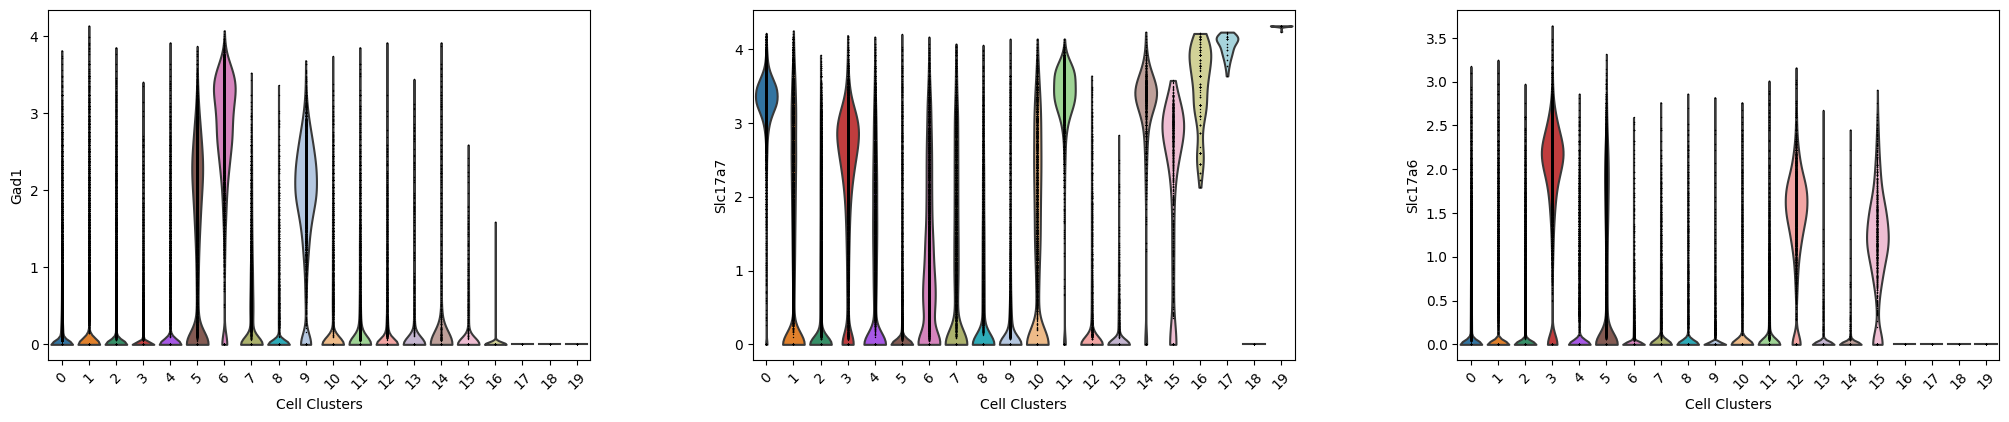

In [ ]:
# Values to change
name = 'Test'
genes = ['Gad1','Slc17a7','Slc17a6']
group = 'leiden'

sc.pl.violin(ad, keys = genes, groupby=group, rotation=45, show=True, jitter=False, xlabel='Cell Clusters', save= name)

## **Heat Map**  - page 10
### Able to generate heat maps based on gene expression per cluster.


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


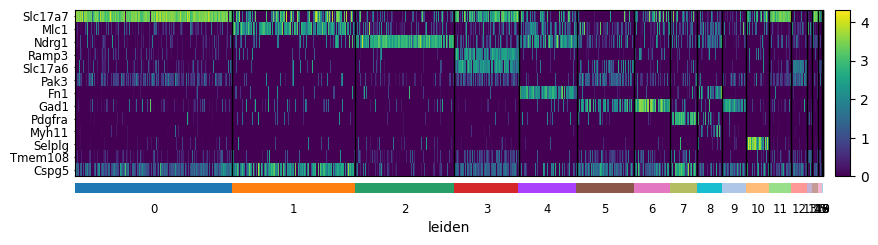

In [ ]:
# Values to change
name = 'Testing'
genes = ['Slc17a7','Mlc1','Ndrg1','Ramp3','Slc17a6','Pak3','Fn1','Gad1','Pdgfra','Myh11','Selplg','Tmem108','Cspg5']
group = 'leiden'

# NO CHANGING
sc.pl.heatmap(ad, genes, groupby=group, swap_axes = True, save=name)

## **Matrix plot**  - page 11
### Able to generate heat maps based on gene expression per cluster.

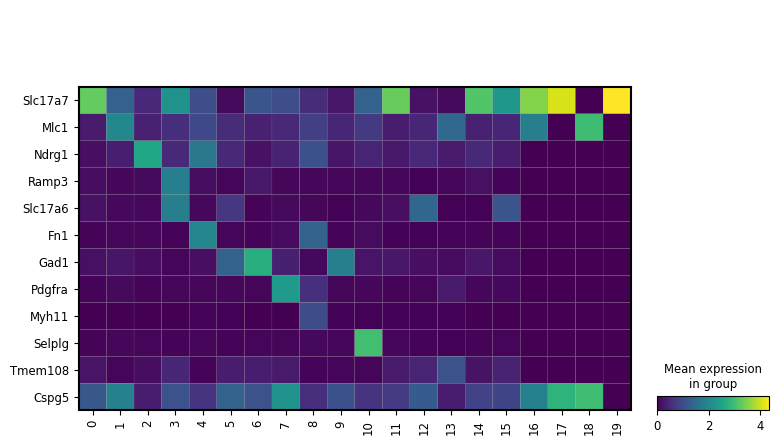

In [ ]:
# Values to change
name = 'Testing'
genes = ['Slc17a7','Mlc1','Ndrg1','Ramp3','Slc17a6','Fn1','Gad1','Pdgfra','Myh11','Selplg','Tmem108','Cspg5']
group = 'leiden'

# NO CHANGING
sc.pl.matrixplot(ad, genes, groupby=group, swap_axes = True, save=name)
#mp = sc.pl.matrixplot(ad, genes, groupby='leiden', swap_axes = True, return_fig=True)
#mp.add_totals().style(edge_color='black').show()

## **Dendrogram** - page 12
### Able to generate a dendrogram, allows you to see the similarity between the clusters.


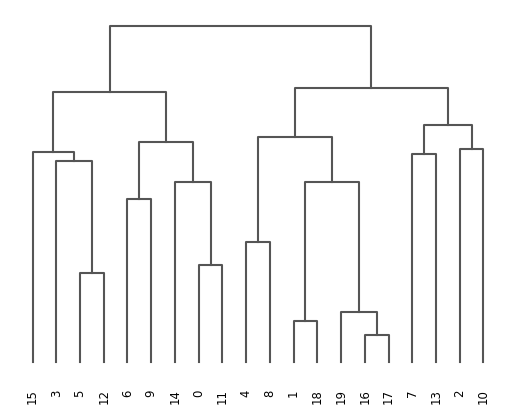

<Axes: >

In [ ]:
# Values to change
name = 'Tesa'
group = 'leiden'

# NO CHANGING
sc.pl.dendrogram(ad, groupby=group, save=name)

## **Spatial Gene Expression** - page 13
### Able to plot the spatial gene expression of a specific set of genes

In [ ]:
# Values to change
name = 'Test'
genes = ['Slc17a7','Slc17a6','Baiap2','Gad1','Selplg','Ndrg1']
group = 'leiden'

# NO CHANGING
genes.insert(0,group)
sc.pl.umap(ad, color=genes, title=name, save=name)
sc.pl.spatial(ad, color=genes, spot_size=30, title=name, save=name)

Output hidden; open in https://colab.research.google.com to view.

# **Manual Annotation** - page 14
## This section is what allows you to manually annotate the cell clusters that you find. These annotations can be used instead of the leiden clusters once completed.

In [ ]:
# TO CHANGE
ad.obs["manual"] = ad.obs["leiden"].map({

    "0": "",
    "1": "",
    "2": "",
    "3": "",
    "4": "",
    "5": "",
    "6": "",
    "7": "",
    "8": "",
    "9": "",
    "10": "",
    "11": "",
    "12": "",
    "13": "",
    "14": "",
    "15": "",
    "16": "",
    "17": "",
    "18": "",

    })


# NO CHANGING
if 'dendrogram_manual' in ad.uns:
  del ad.uns['dendrogram_manual']
ad.obs["manual"] = ad.obs["manual"].replace(np.nan, "other")
ad.obs['manual'] = ad.obs['manual'].astype('category')

# **Project Manual Annatotation Onto Spatial Map**
### This code block draws the new plots based on the manual annotation performed above instead of the leiden clusters (clusters named 0,1,2,3....)

In [ ]:
sc.pl.umap(ad, color="manual")
sc.pl.spatial(ad, color = 'manual', spot_size= 30)